# Estimation of Global Temperature Damage Function

## Effect of Emissions on Temperature

We compute average projected temperatures in each country under RCP7.0, RCP4.5 and RCP2.6 from CMIP6 data.

100%|██████████| 246/246 [1:00:23<00:00, 14.73s/it]


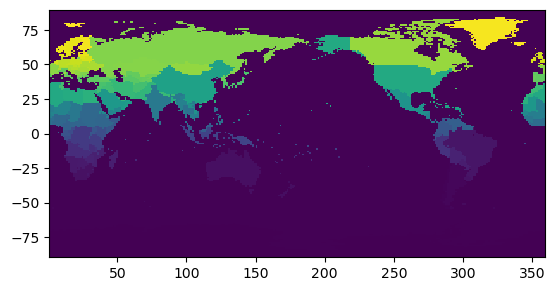

In [881]:
import netCDF4, geopandas, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import georasters as gr


rcp70 = netCDF4.Dataset("data/CMIP6/tas_Amon_GFDL-ESM4_ssp370_r1i1p1f1_gr1_201501-210012.nc") # via download_rcp70.sh from https://aims2.llnl.gov/search
rcp45 = netCDF4.Dataset("data/CMIP6/tas_Amon_GFDL-ESM4_ssp245_r1i1p1f1_gr1_201501-210012.nc") # via download_rcp45.sh from https://aims2.llnl.gov/search
rcp26 = netCDF4.Dataset("data/CMIP6/tas_Amon_GFDL-ESM4_ssp126_r1i1p1f1_gr1_201501-210012.nc") # via download_rcp26.sh from https://aims2.llnl.gov/search
countries = geopandas.read_file('data/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp') # from http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip
population = gr.from_file("data/gpw_v4_population_density_rev11_2020_1_deg.tif") # from https://sedac.ciesin.columbia.edu/downloads/data/gpw-v4/gpw-v4-population-density-rev11/gpw-v4-population-density-rev11_2020_1_deg_tif.zip

time = netCDF4.num2date(rcp26["time"][:], rcp26["time"].units, rcp26["time"].calendar).data
year = [t.year for t in time]
month = [t.month for t in time]
lon, lat = [_.flatten() for _ in np.meshgrid(np.where(rcp70['lon'][:]>180, rcp70['lon'][:]-360, rcp70['lon'][:]), rcp70['lat'][:])]
grid = geopandas.GeoDataFrame(dict(ISO=["NONE"]*len(lat)), geometry=geopandas.GeoSeries(geopandas.points_from_xy(lon, lat)))
pop_density = population.map_pixel(lon, lat).data.clip(0).reshape(rcp70['tas'].shape[1:])[None]
area = lambda lat: np.cos(np.arctan(0.99664718933*np.tan(lat/180*np.pi))) # length of "Circle of Latitude" on GRS80 ellipsoid (relative to equator)
maskmean = lambda arr, keep, weight, axis: np.ma.average(np.ma.masked_array(arr, ~keep), weights=np.broadcast_to(weight, arr.shape), axis=axis)

df = pd.DataFrame(dict(temp70=[], temp45=[], temp26=[], Country=[], Year=[], Month=[]))
for iso, geom in tqdm.tqdm(zip(countries.ISO3, countries.geometry), total=len(countries.ISO3)):
    within = grid.within(geom)
    if not within.any(): within[np.argmin(grid.distance(geom))] = True
    grid.loc[within, "ISO"] = iso
    keep = np.broadcast_to(within.to_numpy().reshape(1, *rcp70["tas"].shape[1:]), rcp70["tas"].shape)
    area_weight = area(rcp70['lat'][:].data[None,:,None])
    pop_weight = area_weight*pop_density
    df = pd.concat([df, pd.DataFrame(dict(
        temp70_areaw=maskmean(rcp70["tas"][:], keep, weight=area_weight, axis=(-2, -1)) - 273.15,
        temp45_areaw=maskmean(rcp45["tas"][:], keep, weight=area_weight, axis=(-2, -1)) - 273.15,
        temp26_areaw=maskmean(rcp26["tas"][:], keep, weight=area_weight, axis=(-2, -1)) - 273.15,
        temp70=maskmean(rcp70["tas"][:], keep, weight=pop_weight, axis=(-2, -1)) - 273.15,
        temp45=maskmean(rcp45["tas"][:], keep, weight=pop_weight, axis=(-2, -1)) - 273.15,
        temp26=maskmean(rcp26["tas"][:], keep, weight=pop_weight, axis=(-2, -1)) - 273.15,
        Country=[iso]*len(year), Year=year, Month=month
    ))])

df.Year = df.Year.astype(int)
df.Month = df.Month.astype(int)

plt.imshow(
    pd.factorize(grid.ISO)[0].reshape(*rcp70["tas"].shape[1:]),
    cmap='viridis', interpolation='nearest', origin='lower',
    extent=[rcp70["lon"][:].min(), rcp70["lon"][:].max(), rcp70["lat"][:].min(), rcp70["lat"][:].max()]
)

df.to_csv("data/CMIP6/temperature_projections_CMIP6.csv", index=False)

Comparing the temperatures and cumulative global emissions between RCPs, we estimate the amount of warming per gigaton CO2-equivalent, measured in °C/GtCO2e. The plots confirm a linear approximation is reasonable.

/tmp/ipykernel_208553/1030376480.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_agg['GtCO2e_cumsum'] = df_agg.groupby('SCENARIO').apply(lambda x:


<Figure size 1000x600 with 0 Axes>

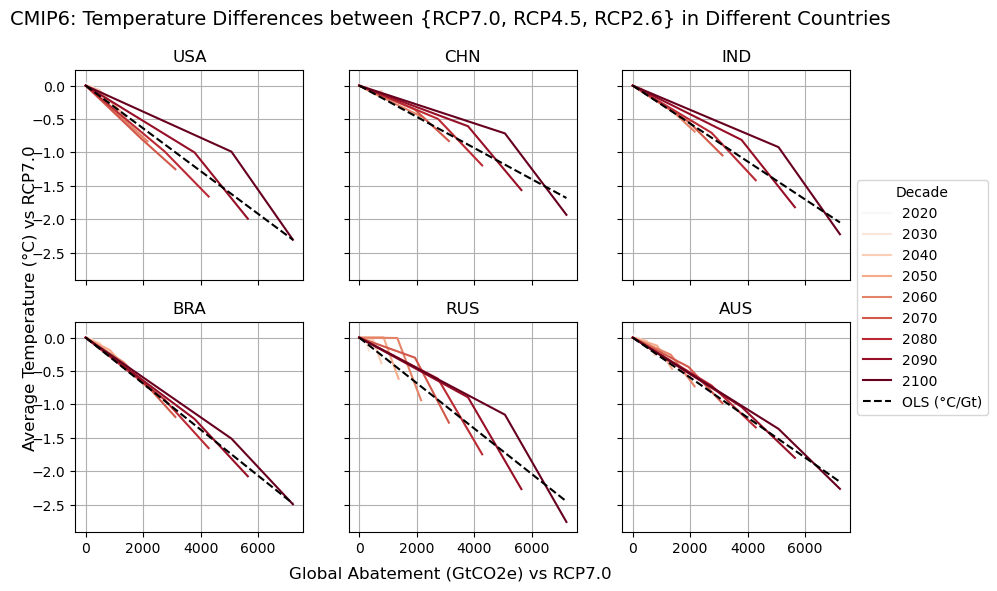

In [2]:
import statsmodels.api as sm

# Compute Linear Approximation To Warming Per GtCO2e For Each Country
# Merge local temperature projections with global abatement under each scenario 
df = pd.read_csv("data/CMIP6/temperature_projections_CMIP6.csv")
df_agg = pd.read_csv("data/CMIP6/SSP_IAM_V2_201811.csv") # CMIP6 "IAM Results" from https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=60

# Filter out and reshape aggregate emissions under RCP7.0, RCP4.5, RCP2.6
df_agg = df_agg.rename(lambda x: "MtCO2ePerYr"+x if str(x).startswith("2") else x, axis=1)
df_agg.SCENARIO = df_agg.SCENARIO.replace({"SSP3-Baseline": "70", "SSP1-26": "26", "SSP2-45": "45"})
df_agg.VARIABLE = df_agg.VARIABLE.replace({
    "Emissions|Kyoto Gases": "MtCO2ePerYr",
    "Diagnostics|MAGICC6|Temperature|Global Mean": "Warming"
})
df_agg = df_agg[
    df_agg.SCENARIO.isin(["70", "26", "45"]) &
    df_agg.MODEL.isin(["MESSAGE-GLOBIOM"]) &
    df_agg.REGION.isin(["World"]) & 
    df_agg.VARIABLE.isin(["MtCO2ePerYr"])
]
df_agg = pd.wide_to_long(df_agg, stubnames="MtCO2ePerYr", i="SCENARIO", j="Year", sep="")

# Compute cumulative sum of CO2 emissions for each scenario
df_agg = df_agg.reset_index().sort_values(['SCENARIO', 'Year']).reset_index(drop=True)
df_agg['GtCO2e_cumsum'] = df_agg.groupby('SCENARIO').apply(lambda x: 
    (x['MtCO2ePerYr'].shift() + x['MtCO2ePerYr'])/2 * (x['Year'] - x['Year'].shift()) / 1000,
    include_groups = True
).fillna(0).groupby(level=0).cumsum().reset_index(level=0, drop=True)
df_agg = df_agg[df_agg.Year % 10 == 0].set_index(['SCENARIO', 'Year'])

# Compute average temperature differences for each country between RCPs
df["Year"] = (df.Year/10).round().mul(10).astype(int) # round to nearest decade
df_avg = df.groupby(["Country", "Year"])[["temp70", "temp45", "temp26"]].mean().reset_index()#.set_index("Year")
df_avg = df_avg[~df_avg.temp70.isna()].reset_index() 

# Smooth temperatures to remove weather variation from counterfactual scenarios
counterfactuals_start = 2030
smoothed = lambda y: pd.Series(sm.nonparametric.lowess(y, y.index, missing="drop")[:,1], index=y.index)
df_avg[["temp70_smoothed", "temp45_smoothed", "temp26_smoothed"]] = df_avg[["temp70", "temp45", "temp26"]]
df_avg.loc[df_avg.Year <= counterfactuals_start, ["temp70_smoothed", "temp45_smoothed", "temp26_smoothed"]] = df_avg.loc[df_avg.Year <= counterfactuals_start, ["temp70", "temp45", "temp26"]].mean(axis=1)
df_avg = df_avg.set_index(["Country", "Year"]).reset_index()
df_avg["temp70_smoothed"] = df_avg.groupby("Country").apply(lambda x: smoothed(x.temp70_smoothed), include_groups=False).reset_index(0, drop=True)
df_avg["temp45_smoothed"] = df_avg.groupby("Country").apply(lambda x: smoothed(x.temp45_smoothed), include_groups=False).reset_index(0, drop=True)
df_avg["temp26_smoothed"] = df_avg.groupby("Country").apply(lambda x: smoothed(x.temp26_smoothed), include_groups=False).reset_index(0, drop=True)
df_avg = df_avg.set_index("Year")

for rcp in ["70", "45", "26"]: 
    df_avg["GtCO2e_cumsum"+rcp] = df_agg.loc[rcp].GtCO2e_cumsum
    df_avg["abatement"+rcp] = df_avg["GtCO2e_cumsum70"] - df_avg["GtCO2e_cumsum"+rcp]
    df_avg["temp_diff"+rcp] = df_avg[f"temp{rcp}_smoothed"] - df_avg["temp70_smoothed"]

df_avg = df_avg.reset_index().set_index(["Country", "Year"])
df_avg.to_csv("data/abatement_and_temperature_projections_CMIP6.csv")

# Create a scatter plot with abatement on x-axis and temp on y-axis
warming_per_GtCO2e = {"Country": [], "°C/GtCO2e": []}
plot_countries = {"USA":0, "CHN":1, "IND":2, "BRA":3, "RUS":4, "AUS":5}
df_long = pd.wide_to_long(
    df_avg[["temp_diff70", "abatement70", "temp_diff45", "abatement45", "temp_diff26", "abatement26"]].reset_index(),
    stubnames=["temp_diff", "abatement"], i=["Country", "Year"], j="rcp", sep=""
).reset_index().set_index("Country")

plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle("CMIP6: Temperature Differences between {RCP7.0, RCP4.5, RCP2.6} in Different Countries", fontsize=14)
for country in df_long.index.unique():
    # compute OLS between relative temperature and relative abatement (without intercept)
    coef =  sm.OLS(df_long.loc[country].temp_diff, df_long.loc[country].abatement).fit().params.iloc[0]
    
    # append to df
    warming_per_GtCO2e["Country"].append(country)
    warming_per_GtCO2e["°C/GtCO2e"].append(coef)
    
    # possibly plot
    if country in plot_countries:
        idx = plot_countries[country]
        ax = axes[idx // 3, idx % 3]
        for yr in df_long.Year.unique():
            data = df_long.reset_index().set_index(["Country", "Year"]).loc[(country, yr), ["temp_diff", "abatement"]]
            color = plt.cm.RdBu((df_long.Year.max() - yr) / (df_long.Year.max() - df_long.Year.min())/2)
            ax.plot(data["abatement"], data["temp_diff"], color=color, label=str(yr))
        ax.plot(data["abatement"], data["abatement"]*coef, color="black", label="OLS (°C/Gt)", linestyle="--")
        ax.set_title(f"{country}")
        ax.grid(True)

fig.text(0.5, 0.04, "Global Abatement (GtCO2e) vs RCP7.0", ha='center', va='center', fontsize=12)
fig.text(0.08, 0.5, "Average Temperature (°C) vs RCP7.0", ha='center', va='center', rotation='vertical', fontsize=12)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), title="Decade", ncol=1)
plt.savefig("figures/warming_per_GtCO2e.svg")
plt.show()


warming_per_GtCO2e = pd.DataFrame(warming_per_GtCO2e)
warming_per_GtCO2e.to_csv("data/CMIP6/warming_per_GtCO2e.csv", index=False)

## Effect of Temperatures on National Income

First, we combine temperature satellite data from NASA's MERRA-2 with national income from Penn World Tables

Aggregating Temperature Data 2021/9: 100%|██████████| 524/524 [28:33<00:00,  3.27s/it] 


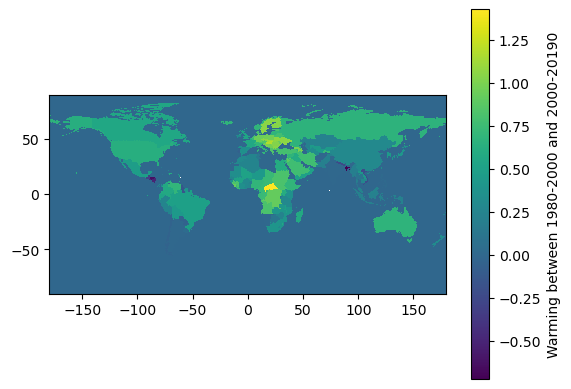

In [8]:
import os, tqdm, netCDF4, geopandas, warnings
import pandas as pd
import numpy as np
import georasters as gr

# Assemble Panel Of Temperatures from 1980-2023
countries = geopandas.read_file('data/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp') # from http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip
files = [f for f in os.listdir("data/NASA_MERRA2/") if f.endswith(".nc4")]
files.sort()
ds = netCDF4.Dataset("data/NASA_MERRA2/"+files[0])
population = gr.from_file("data/gpw_v4_population_density_rev11_2020_1_deg.tif") # from https://sedac.ciesin.columbia.edu/downloads/data/gpw-v4/gpw-v4-population-density-rev11/gpw-v4-population-density-rev11_2020_1_deg_tif.zip

lon, lat = [_.flatten() for _ in np.meshgrid(ds['lon'][:], ds['lat'][:])]
pop_density = population.map_pixel(lon.clip(-179,179), lat.clip(-89,89)).data.clip(0).reshape(ds['T2M'].shape[1:])[None]
grid = geopandas.GeoDataFrame(dict(temp=[0]*len(lat)), geometry=geopandas.GeoSeries(geopandas.points_from_xy(lon, lat)))
area = lambda lat: np.cos(np.arctan(0.99664718933*np.tan(lat/180*np.pi))) # length of "Circle of Latitude" on GRS80 ellipsoid (relative to equator)
maskmean = lambda arr, keep, weight, axis: np.ma.average(np.ma.masked_array(arr, ~keep), weights=np.broadcast_to(weight, arr.shape), axis=axis)


country_masks = {}
for iso, geom in (bar := tqdm.tqdm(zip(countries.ISO3, countries.geometry), total=len(countries.ISO3))):
    bar.set_description(f"Computing Country Masks {iso}")
    within = grid.within(geom)
    if not within.any(): within[np.argmin(grid.distance(geom))] = True
    country_masks[iso] = within.to_numpy().reshape(1, *ds["T2M"].shape[1:])

df_temp = pd.DataFrame(dict(temp=[], Country=[], Year=[], Month=[]))
for f in (bar := tqdm.tqdm(files)):
    ds = netCDF4.Dataset("data/NASA_MERRA2/"+f)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        time = netCDF4.num2date(ds["time"][0], ds["time"].units)
    bar.set_description(f"Aggregating Temperature Data {time.year}/{time.month}")
    for iso, mask in country_masks.items():
        df_temp = pd.concat([df_temp, pd.DataFrame(dict(
            temp_areaw=maskmean(ds["T2M"][:], keep=mask, weight=area(ds['lat'][:][None,:,None]), axis=(-2, -1)) - 273.15,
            temp=maskmean(ds["T2M"][:], keep=mask, weight=area(ds['lat'][:][None,:,None])*pop_density, axis=(-2, -1)) - 273.15,
            Country=[iso], Year=[time.year], Month=[time.month]
        ))])

df_temp.Year = df_temp.Year.astype(int)
df_temp.Month = df_temp.Month.astype(int)
df_temp.to_csv("data/NASA_MERRA2/past_temperatures_NASA_MERRA2.csv", index=False)

# Merge the panel with national income data from Penn World Tables
df_temp = pd.read_csv("data/NASA_MERRA2/past_temperatures_NASA_MERRA2.csv")
df_temp = df_temp.groupby(["Country", "Year"]).temp.mean().reset_index()
df_income = pd.read_excel("data/pwt1001.xlsx", sheet_name=2, engine="openpyxl")
df = df_temp.merge(df_income, left_on=["Country", "Year"], right_on=["countrycode", "year"], how="inner").drop(columns=["countrycode", "year"])
df.sort_values(["Country", "Year"], inplace=True)
df.to_csv("data/past_income_and_temperatures.csv", index=False)

# Plot warming in each country, as sanity check
from matplotlib import pyplot as plt
warming = ds["T2M"][:]*0
for iso in df.Country.unique():
    warming[country_masks[iso]] = df[df.Country==iso].temp.agg(lambda x: x.to_numpy()[-20:].mean()-x.to_numpy()[:20].mean())
plt.imshow(
    warming[0], cmap='viridis', interpolation='nearest', origin='lower',
    extent=[ds["lon"][:].min(), ds["lon"][:].max(), ds["lat"][:].min(), ds["lat"][:].max()]
)
plt.colorbar(label="Warming between 1980-2000 and 2000-2190" )
plt.show()

Next, we de-trend temperature and logGDP.

/var/folders/r8/c1sfx90d2jnfdqrvp2rnwxkh0000gn/T/ipykernel_33848/1067179202.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["logGDP_trend"] = df.groupby("Country").apply(lambda x:
/var/folders/r8/c1sfx90d2jnfdqrvp2rnwxkh0000gn/T/ipykernel_33848/1067179202.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["temp_trend"] = df.groupby("Country").apply(lambda x:


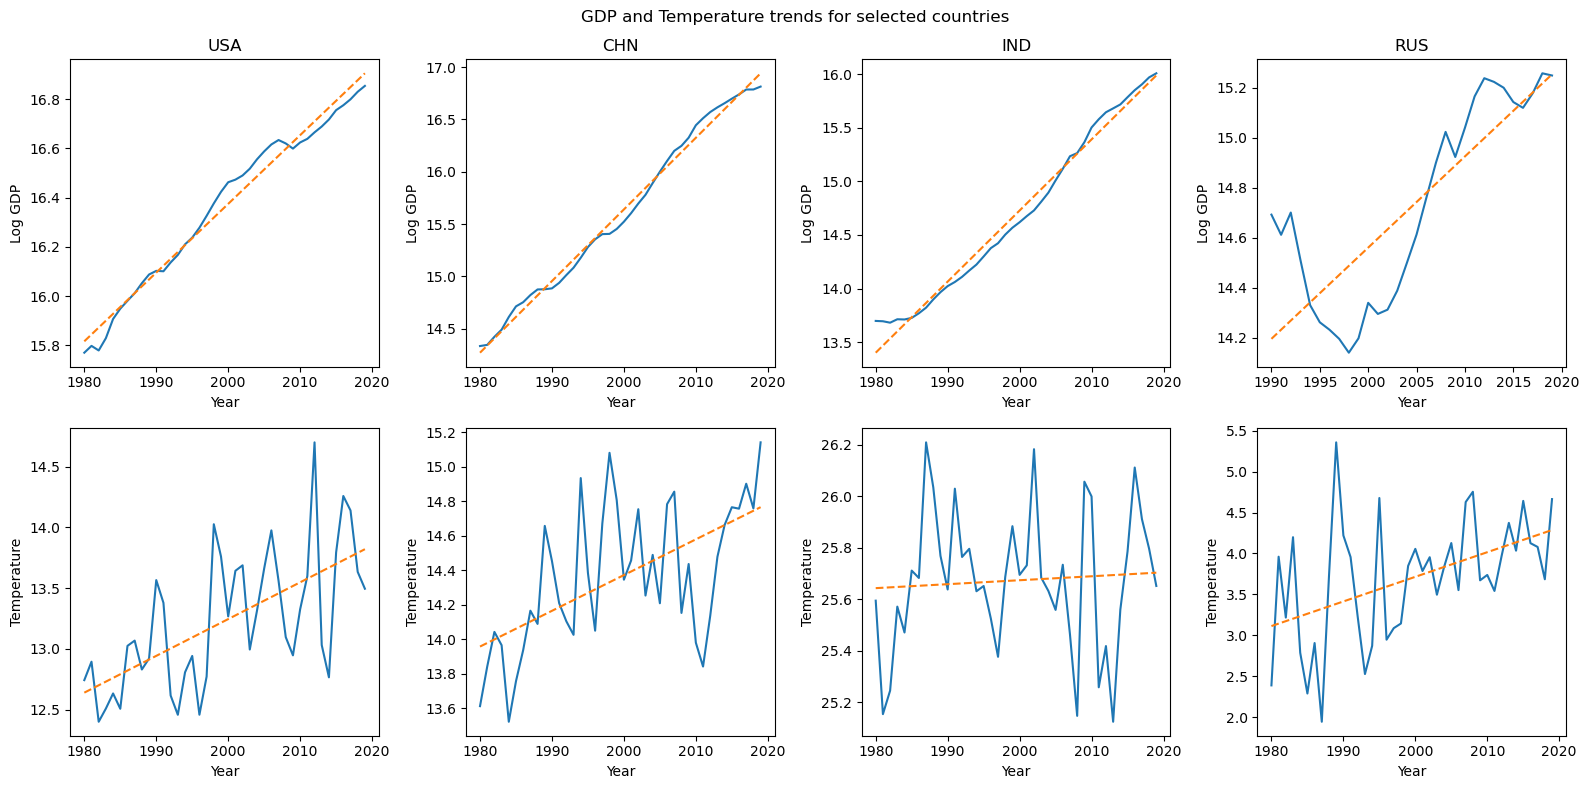

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt

df = pd.read_csv("data/past_income_and_temperatures.csv")
df = df[~df.Country.isin(["BRB", "DMA", "MDV", "MUS", "STP", "VCT", "BMU", "CPV", "CYM", "SYC"])].reset_index(drop=True)

df["logGDP"] = np.log(df.rgdpe)
df["logGDP_trend"] = df.groupby("Country").apply(lambda x:
    sm.OLS(x["logGDP"], sm.add_constant(x["Year"]), missing='drop').fit().fittedvalues
).reset_index(level=0, drop=True)
df["temp_trend"] = df.groupby("Country").apply(lambda x:
    sm.OLS(x["temp"], sm.add_constant(x["Year"]), missing='drop').fit().fittedvalues
).reset_index(level=0, drop=True)
df["logGDP_residual"] = df["logGDP"] - df["logGDP_trend"]
df["temp_residual"] = df["temp"] - df["temp_trend"]

countries = ['USA', 'CHN', 'IND', "RUS"]  # Plot countries: USA, China, India, Russia
fig, axs = plt.subplots(2, len(countries), figsize=(4*len(countries), 8))

for i, iso in enumerate(countries):
    # GDP plot
    axs[0, i].plot(df[df.Country==iso].Year, df[df.Country==iso].logGDP)
    axs[0, i].plot(df[df.Country==iso].Year, df[df.Country==iso].logGDP_trend, linestyle="--")
    axs[0, i].set_title(f'{iso}')
    axs[0, i].set_xlabel('Year')
    axs[0, i].set_ylabel('Log GDP')

    # Temperature plot
    axs[1, i].plot(df[df.Country==iso].Year, df[df.Country==iso].temp)
    axs[1, i].plot(df[df.Country==iso].Year, df[df.Country==iso].temp_trend, linestyle="--")
    axs[1, i].set_xlabel('Year')
    axs[1, i].set_ylabel('Temperature')

plt.suptitle("GDP and Temperature trends for selected countries")
plt.tight_layout()
plt.savefig("figures/gdp_and_temp_trends.svg")
plt.show()

Now, we estimate the impact of temperature fluctuations on logGDP. We take into account spillovers: hot or cold years in other countries may affect your GDP, e.g. shortages in foreign food supply may drive up your costs of food, or a warm winter in Europe may reduce profits for net energy exporters. Because arbitrageurs equalize global prices, we expect these spillovers to occur regardless of who is trading with whom directly.

We regularize spillovers via a ridge penalty, and determine its relugarization strength $\alpha$ via cross-validation.

$$\widehat{\beta} = \arg\min_{\beta} \ \sum_i \left(\Delta\log \text{Y}_{it} - \sum_j \beta_{ij}\Delta \text{T}_{jt}\right)^2 + \alpha \sum_{j\neq i}\beta_{ij}^2 $$


  0%|          | 0/175 [00:00<?, ?it/s]49/50 | ZWE: 100%|██████████| 175/175 [01:38<00:00,  1.77it/s]


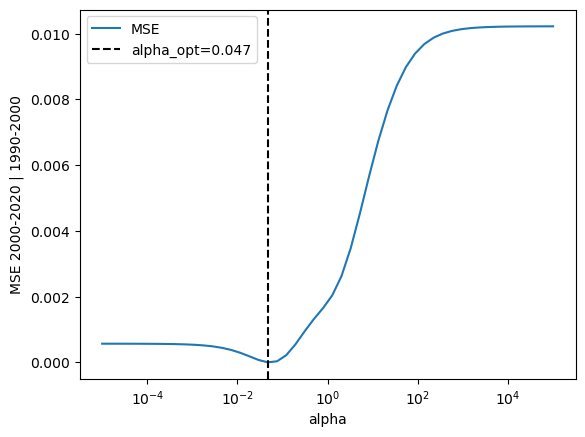

In [76]:
import tqdm
dT = df.pivot_table(index="Year", columns="Country", values="temp_residual")
dlogY = df.pivot_table(index="Year", columns="Country", values="logGDP_residual")

alpha_grid = np.logspace(-5, 5, 50)
mad_loss_grid = np.zeros((alpha_grid.shape[0], len(dlogY.columns)))
mse_loss_grid = np.zeros((alpha_grid.shape[0], len(dlogY.columns)))
years = dT.index
train_split = 2000

for j, iso in enumerate(bar:= tqdm.tqdm(dlogY.columns)):
    penalty = (dT.columns != iso).astype(float) #/df.groupby("Country").rgdpe.mean()[dlogY.columns].to_numpy() # doesnt really make a difference
    for i, alpha in enumerate(alpha_grid):
        bar.set_description(f"{i}/{len(alpha_grid)} | {iso}")
        dlogY_hat = sm.OLS(dlogY[iso].loc[years<=train_split], dT.loc[years<=train_split], missing='drop').fit_regularized(
            alpha=alpha*(penalty/penalty.mean()), L1_wt=0.0 # apply L2 only to spillovers, and normalize by gdp
        ).predict(dT.loc[years>train_split])
        mse_loss_grid[i,j] += ((dlogY_hat-dlogY[iso].loc[years>train_split])**2).mean()

alpha_opt = alpha_grid[np.argmin(mse_loss_grid.mean(axis=1))]
argmin = np.argmin(mse_loss_grid.mean(axis=1))
plt.plot(alpha_grid, mse_loss_grid.mean(axis=1)-mse_loss_grid.mean(axis=1).min(), label="MSE")
plt.axvline(alpha_opt, color="k", linestyle="--", label=f"alpha_opt={alpha_opt:.2}")
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("MSE 2000-2020 | 1990-2000")
plt.legend()
plt.show()


While $\widehat{\beta}_{ii}$ gives us the marginal "direct effect" of warming in country $i$, the "total effect" of marginal global warming is better captured by:

$$\bar{\beta}_i = \sum_j \widehat{\beta}_{ij}\frac{\widehat{\gamma}_{j}}{\widehat{\gamma}_i}$$

i.e. the sum of the direct effects of warming in each country, weighted by how fast they will warm relative to country $i$. Here, $\widehat{\gamma}_{j}$ denote the OLS coefficients (in units of °C/GtCO2e) estimated from CMIP6 simulation data in the first chapter of this notebook.


Finally, we'd like to get an insight into how  $\bar{\beta}_i$ may change as countries get warmer. We will look at
 1) the cross-country relationship between $\bar{\beta}_i$ and average temperature $\bar{T}_i=\sum_t T_{it}$
 2) how $\bar{T}_i, \bar{\beta}_i$ varies within-country, between the early (1980-2000) and late (2000-2020) halves of our data

ZWE: 100%|██████████| 171/171 [00:01<00:00, 121.91it/s]


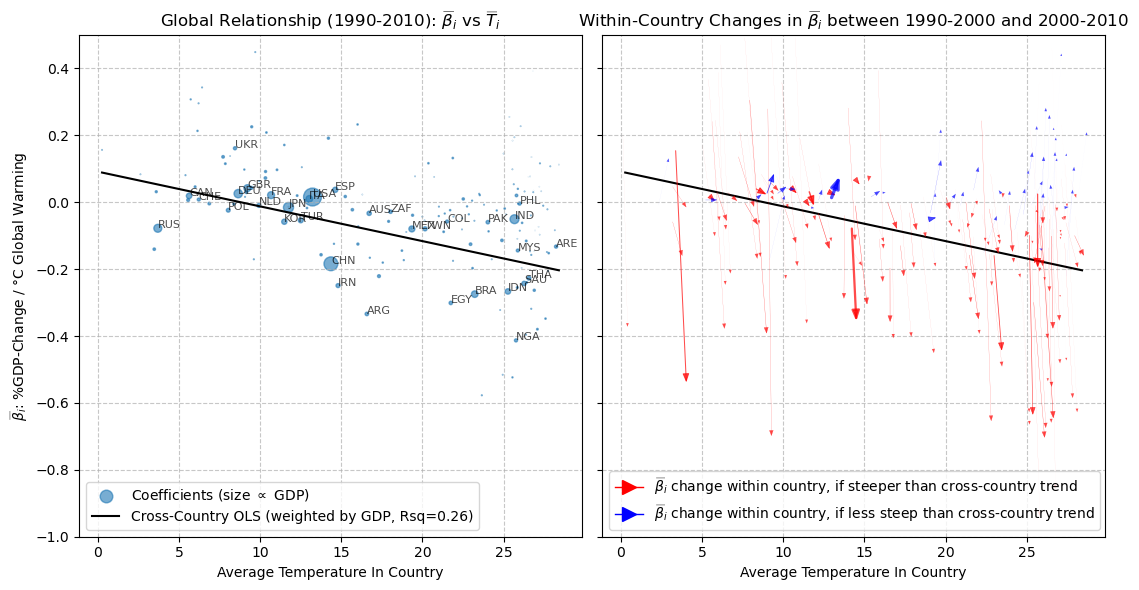

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          dlogY/°C_full   R-squared:                       0.209
Model:                            WLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     44.60
Date:                Tue, 07 Jan 2025   Prob (F-statistic):           3.33e-10
Time:                        17:20:35   Log-Likelihood:                -51.446
No. Observations:                 171   AIC:                             106.9
Df Residuals:                     169   BIC:                             113.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0914      0.025      3.660      0.000       0.042       0.141
temp_full     -0.0104      0.002     -6.679      0.000      -0.013      -0.007
==============================================================================
Omnibus:                      181.042   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6043.469
Skew:                          -3.882   Prob(JB):                         0.00
Kurtosis:                      31.070   Cond. No.                         41.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# Estimate Marginal Damages for each country within
# full (1980-2020), early (1980-2000) and late (2000-2020) periods
import tqdm
dT = df.pivot_table(index="Year", columns="Country", values="temp_residual")
dlogY = df.pivot_table(index="Year", columns="Country", values="logGDP_residual")
warming = pd.read_csv("data/CMIP6/warming_per_GtCO2e.csv").set_index("Country")

warming = warming[warming.index.isin(dlogY.columns)]
warming["dlogY/°C_full"] = np.nan
warming["dlogY/°C_early"] = np.nan
warming["dlogY/°C_late"] = np.nan

alpha_opt = 0.047
for j, iso in enumerate(bar := tqdm.tqdm(dlogY.columns)):
    bar.set_description(f"{iso}")
    penalty = (dT.columns != iso).astype(float)#/df.groupby("Country").rgdpe.mean()[dlogY.columns].to_numpy()
    params_full = sm.OLS(dlogY[iso], dT, missing='drop').fit_regularized(
        alpha=alpha_opt*penalty/penalty.mean(), L1_wt=0 # apply L2 only to spillovers
    ).params
    split = 2000
    params_early = sm.OLS(dlogY[iso].loc[dT.index<split], dT.loc[dT.index<split], missing='drop').fit_regularized(
        alpha=alpha_opt*penalty/penalty.mean(), L1_wt=0 # apply L2 only to spillovers
    ).params
    params_late = sm.OLS(dlogY[iso].loc[dT.index>=split], dT.loc[dT.index>=split], missing='drop').fit_regularized(
        alpha=alpha_opt*penalty/penalty.mean(), L1_wt=0 # apply L2 only to spillovers
    ).params
    warming.loc[iso, "dlogY/°C_full"]  = (pd.Series(params_full, index=dT.columns) * warming["°C/GtCO2e"]).sum() / warming["°C/GtCO2e"].loc[iso]
    warming.loc[iso, "dlogY/°C_early"] = (pd.Series(params_early, index=dT.columns)* warming["°C/GtCO2e"]).sum() / warming["°C/GtCO2e"].loc[iso]
    warming.loc[iso, "dlogY/°C_late"]  = (pd.Series(params_late, index=dT.columns) * warming["°C/GtCO2e"]).sum() / warming["°C/GtCO2e"].loc[iso]

warming["temp_full"] = df.groupby("Country").temp.mean()
warming["temp_early"] = df[df.Year<2000].groupby("Country").temp.mean()
warming["temp_late"] = df[df.Year>=2000].groupby("Country").temp.mean()
warming["gdp_full"] = df.groupby("Country").rgdpo.mean()
warming["gdp_late"] = df[df.Year>=2000].groupby("Country").rgdpo.mean()
warming["gdp_early"] = df[df.Year<2000].groupby("Country").rgdpo.mean()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

# Left subplot: Scatterplot of full estimates with trend line
ax1.scatter(warming["temp_full"], warming["dlogY/°C_full"], s=warming["gdp_full"]/warming["gdp_full"].mean()*5, alpha=0.6, label="Coefficients (size $\propto$ GDP)")
temp_grid = np.linspace(warming["temp_full"].min(), warming["temp_full"].max(), 100)
cross_country = sm.WLS(warming["dlogY/°C_full"], sm.add_constant(warming["temp_full"]), weights=warming["gdp_full"], missing='drop').fit()
ax1.plot(temp_grid, cross_country.predict(sm.add_constant(temp_grid)), color="k", label="Cross-Country OLS (weighted by GDP, Rsq=0.26)")
# Add labels for each country
for idx, row in warming.iterrows():
    if row['gdp_full'] > warming['gdp_full'].quantile(0.80): # plot labels for the 20% largest economies
        ax1.annotate(idx, (row['temp_full'], row['dlogY/°C_full']), 
                     xytext=(0, 0), textcoords='offset points', 
                 fontsize=8, alpha=0.7)

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_title("Global Relationship (1990-2010): $\\widebar{\\beta}_i$ vs $\\widebar{T}_i$ ")
ax1.set_xlabel("Average Temperature In Country")
ax1.set_ylim(-1, 0.5)
ax1.set_ylabel("$\\widebar{\\beta}_i$: %GDP-Change / °C Global Warming")
ax1.legend()

# Right subplot: Arrow plot
ax2.scatter(warming["temp_full"], warming["dlogY/°C_full"], alpha=0)
ax2.plot(temp_grid, cross_country.predict(sm.add_constant(temp_grid)), color="k")#, label="Cross-Country OLS (weighted by GDP)")
for idx, row in warming.iterrows():
    start = [row['temp_early'], min(row['dlogY/°C_early'], 0.5)]
    end = [row['temp_late'], row['dlogY/°C_late']]
    steeper = ((end[1]-start[1]) / max(end[0]-start[0], 1e-7)) < cross_country.params["temp_full"]
    if start[1] < ax1.get_ylim()[0]: start[1] = ax1.get_ylim()[0] # for visibility. This is conservative as only makes red arrows less steep
    length = (((end[1]-start[1])/(ax1.get_ylim()[1]-ax1.get_ylim()[0]))**2 + ((end[0]-start[0])/(ax1.get_xlim()[1]-ax1.get_xlim()[0]))**2)**0.5
    width = (row["gdp_full"]/warming["gdp_full"].mean())**(0.7) # exponent to make sizes a little more homogenous for visibility
    ax2.annotate('', xy=end, xytext=start,
                 arrowprops=dict(arrowstyle='-|>,head_width=.15', color='red' if steeper else 'blue', linewidth=0.2*width, mutation_scale=10*width**0.2, alpha=0.7), alpha=0.7)

ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_title("Within-Country Changes in $\\widebar{\\beta}_i$ between 1990-2000 and 2000-2010")
ax2.set_xlabel("Average Temperature In Country")


# Add a legend for the arrow colors
ax2.plot([], [], color='red', marker='>', markersize=10, label='$\\widebar{\\beta}_i$ change within country, if steeper than cross-country trend', linewidth=1)
ax2.plot([], [], color='blue', marker='>', markersize=10, label='$\\widebar{\\beta}_i$ change within country, if less steep than cross-country trend', linewidth=1)
ax2.legend()

plt.tight_layout()
plt.savefig("figures/marginal_damages.svg")
plt.show()

cross_country.summary()

In [4]:
f"""T_opt: {-cross_country.params["const"] / cross_country.params["temp_full"]}"""

'T_opt: 8.801701775199463'

We find that the marginal %-damages per °C of global warming increase approximately linearly with average temperature. The cross-country relationship is well-approximated by:

$$\bar{\beta}_i = \frac{d\log Y_i}{d\text{T}_i} = \sum_{j}\hat{\beta}_{ij}\frac{\hat\gamma_j}{\hat\gamma_i} \approx -0.01( T_i- T_{opt}), \quad T_{opt} = 8.8$$


$T_{opt} = 10.64$ is the tempature at which countries tend to be indifferent to warming. By the Envelope Theorem, integrating the differential equation implied by htis cross-country relationship should recover the global effect of temperature:

$$\log Y_{it} \propto -0.01 \frac{(T_{it}-T_{opt})^2}{2} \quad \implies \quad Y_{it} \propto \exp\left(-0.01 \frac{(T_{it}-T_{opt})^2}{2}\right)$$



On the right plot, we see that this cross-country relationship almost universally underestimated the increase in damages from warming observed historically within countries. This is expected, as countries had millenia to adapt to local temperatures, while changes now occur over decades. The right plot can thus be interpreted as showing the short-run marginal damages, while the left plot is more indicative of the long-term relationship if temperatures were to stabilize. In what follows, we will conservatively use the relationship displayed by the left plot.


# Estimated Present Willingness To Pay To Avoid Warming

Using the previous estimate, and the price of long-run government debt for each country, we can estimate each country's present willingness to pay to avoid a gigaton of CO2 emissions, i.e. the national social cost of carbon, as the amount of debt it could take on today that it could fully repay with the additional future national income it will enjoy if the global warming caused by it would not occur.

For this, we need a baseline temperature and GDP growth scenario, which we will take to be RCP7/SSP3.

100%|██████████| 1000/1000 [00:20<00:00, 49.50it/s]
/var/folders/r8/c1sfx90d2jnfdqrvp2rnwxkh0000gn/T/ipykernel_8623/3880942663.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_income = df_income.groupby(["Country", "Year"]).GDP.mean() #.agg(lambda x: x.quantile(0.33, interpolation="linear")) # consider bottom third quantile to be conservative about growth
/var/folders/r8/c1sfx90d2jnfdqrvp2rnwxkh0000gn/T/ipykernel_8623/3880942663.py:51: UserWarning: Warning: converting a masked element to nan.
  geom_average = lambda x, **kwargs: float(np.exp(np.ma.average(np.ma.masked_invalid(np.log(x)), **kwargs)))


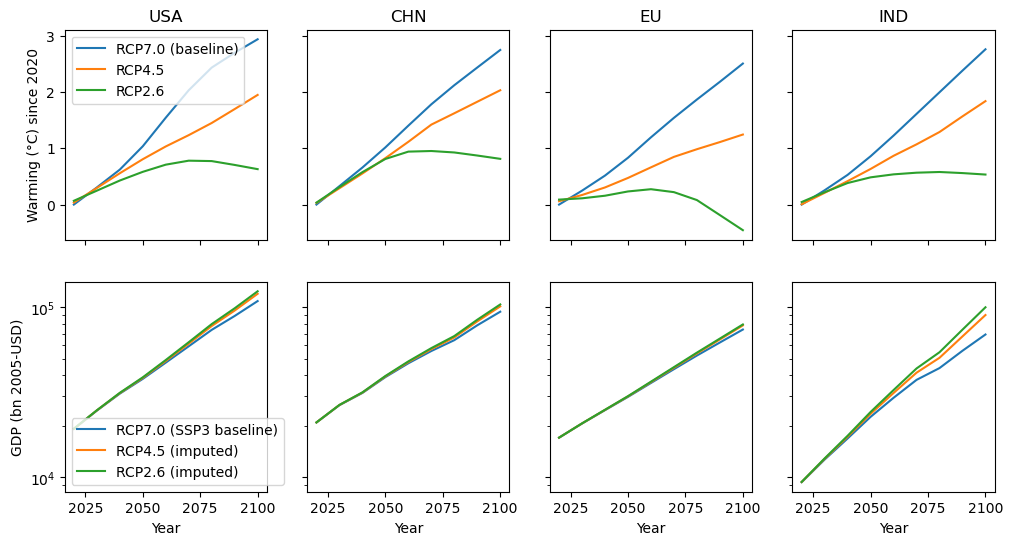

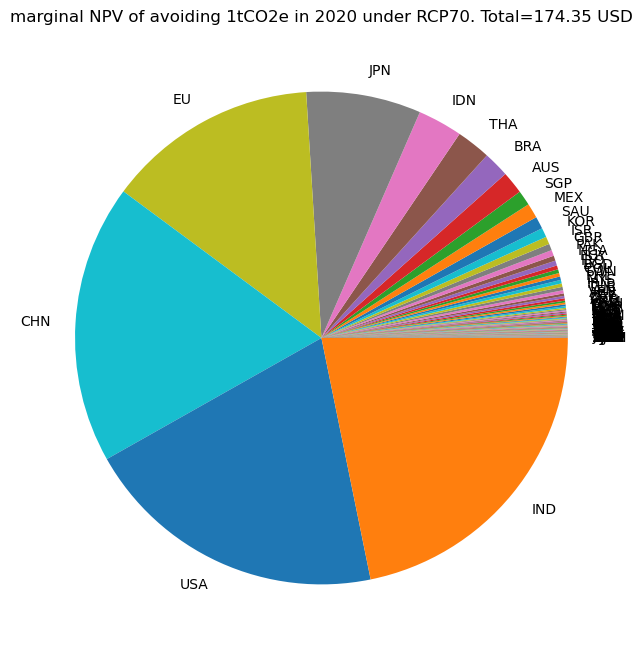

In [51]:
## load growth projections from SSP3 (RCP7) scenario from https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=60
#df_income = pd.read_csv("data/SspDb_country_data_2013-06-12.csv")
#df_income = df_income[df_income.SCENARIO.str.contains("SSP3_v9_130219") & df_income.VARIABLE.str.startswith("GDP")]
#df_income.rename(dict(zip(df_income.columns[5:], df_income.columns[5:].astype(int))), axis=1, inplace=True)
#df_income = df_income.melt(id_vars=["REGION"], var_name="YEAR", value_name="GDP", value_vars = df_income.columns[5:]).dropna()
#df_income = df_income.rename({"REGION":"Country", "YEAR":"Year"}, axis=1)
#df_income = df_income.set_index(["Country", "Year"])
# Load growth projections from RFF-SPs https://zenodo.org/record/6016583/files/rffsps_v5.7z (are meant to be actual posterior samples, unlike SSPs)
import os, tqdm
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
files = [f for f in os.listdir("data/pop_income") if f.endswith(".feather")]
df_income = pd.DataFrame()
for i in tqdm.tqdm(range(1000)):
    df_income = pd.concat([df_income, pd.read_feather(f"data/pop_income/{files[i]}")], axis=0)
df_income.GDP /= 1000 # was in millions of 2011 USD, now billions. Will convert to 2020 USD below.
df_income = df_income.groupby(["Country", "Year"]).GDP.mean() #.agg(lambda x: x.quantile(0.33, interpolation="linear")) # consider bottom third quantile to be conservative about growth


# load temperature projections from RCP7.0, RCP4.5 and RCP2.6 scenarios from abatement_and_temperature_projections_CMIP6.csv
df_proj = pd.read_csv("data/abatement_and_temperature_projections_CMIP6.csv").rename({'iso':'Country', 'yr': 'Year'}, axis=1)
df_proj = df_proj[~df_proj.Country.isin(["BRB", "DMA", "MDV", "MUS", "STP", "VCT", "CPV"])].reset_index(drop=True)
df_proj = df_proj[df_proj.Year.isin(df_income.reset_index().Year.unique())].reset_index(drop=True)
df_proj = df_proj[df_proj.Country.isin(df_income.reset_index().Country.unique())].reset_index(drop=True)
df_proj['gdp70'] = df_income.loc[zip(df_proj.Country, df_proj.Year)].reset_index().GDP

# merge in the temperature coefficients estimated in the previous section
df_warming = pd.read_csv("data/CMIP6/warming_per_GtCO2e.csv").set_index("Country")["°C/GtCO2e"]
df_proj["warming_per_GtCO2e"] = [df_warming.loc[i] for i in df_proj.Country]

# load national June 2024 10yr-bond rates from 
# https://www.statista.com/statistics/1211855/ten-year-government-bond-yield-country/
# or https://www.statista.com/statistics/1254148/ten-year-government-bond-yields-largest-economies/
bond_rates = pd.read_excel("data/worldwide-10-year-government-bond-yield-by-country-2024.xlsx", sheet_name="Data", skiprows=4, names=["Country", "Rate", "Unit"], index_col=1).iloc[:,1:].drop(index=["Taiwan"])
iso_regions = pd.read_csv("data/iso_regions.csv").set_index("name")
iso_regions.index = iso_regions.index.str.replace("Korea, Republic of", "South Korea")
bond_rates.index = [iso_regions.loc[iso_regions.index.str.startswith(name), "alpha-3"].iloc[0] for name in bond_rates.index]
df_proj["bond_rate"] = [(bond_rates.loc[c].Rate/100 if c in bond_rates.index else float("nan")) for c in df_proj.Country]
df_proj = df_proj.set_index(["Country", "Year"])

# Converting from nominal rates to real rates (since we only have real income projections) is hard, because we don't see inflation expectations in the data.
# We will use the 2024 breakeven rate for US, and use conservatively low projections for China, EU and India, where no breakeven rates are available, to err on the higher end of real cost of capital.
inflation = {'USA': 0.023, 'CHN': 0.01, 'EU': 0.022, 'IND': 0.04}

# Merge EU
EU = ["AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", "DEU",
      "GRC", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD", "POL", "PRT",
      "ROU", "SVK", "SVN", "ESP", "SWE"]
geom_average = lambda x, **kwargs: float(np.exp(np.ma.average(np.ma.masked_invalid(np.log(x)), **kwargs)))
df_proj = (df_proj.reset_index()
           .pipe(lambda x: pd.concat([x, x.query("Country in @EU").assign(Country="EU")], ignore_index=True, axis=0))
           .pipe(lambda df_proj: df_proj.groupby(['Country', 'Year']).agg(
               temp70=("temp70", lambda x: np.average(x, weights=df_proj.loc[x.index, "gdp70"])), 
               temp45=("temp45", lambda x: np.average(x, weights=df_proj.loc[x.index, "gdp70"])),
               temp26=("temp26", lambda x: np.average(x, weights=df_proj.loc[x.index, "gdp70"])),
               temp70_smoothed=("temp70_smoothed", lambda x: np.average(x, weights=df_proj.loc[x.index, "gdp70"])), 
               temp45_smoothed=("temp45_smoothed", lambda x: np.average(x, weights=df_proj.loc[x.index, "gdp70"])),
               temp26_smoothed=("temp26_smoothed", lambda x: np.average(x, weights=df_proj.loc[x.index, "gdp70"])),
               abatement70=("abatement70", lambda x: np.average(x, weights=df_proj.loc[x.index, "gdp70"])),
               abatement45=("abatement45", lambda x: np.average(x, weights=df_proj.loc[x.index, "gdp70"])),
               abatement26=("abatement26", lambda x: np.average(x, weights=df_proj.loc[x.index, "gdp70"])),
               gdp70=("gdp70", "sum"),
               bond_rate=("bond_rate", lambda x: geom_average(1+x, weights=df_proj.loc[x.index, "gdp70"])-1),
               warming_per_GtCO2e=("warming_per_GtCO2e", lambda x: np.average(x, weights=df_proj.loc[x.index, "gdp70"])),
            ))
            .pipe(lambda x: x.assign(inflation_longrun=lambda x: [inflation.get(c, 0.01) for c in x.index.get_level_values("Country")]))
)

# Impute GDP using estimated global relationship
T_opt = 8.8
slope = -0.01
df_proj["gdp45_imputed"] = df_proj.gdp70 * np.exp(slope*((df_proj.temp70_smoothed + df_proj["warming_per_GtCO2e"] * df_proj["abatement45"] - T_opt)**2-(df_proj.temp70_smoothed - T_opt)**2)/2)
df_proj["gdp26_imputed"] = df_proj.gdp70 * np.exp(slope*((df_proj.temp70_smoothed + df_proj["warming_per_GtCO2e"] * df_proj["abatement26"] - T_opt)**2-(df_proj.temp70_smoothed - T_opt)**2)/2)

# Impute real interest rate on government debt
df_proj["real_bond_rate"] = df_proj.bond_rate-df_proj.inflation_longrun
df_proj.to_csv("data/combined_projections.csv")

# Plot temperature and GDP projections
countries = ["USA", "CHN", "EU", "IND"]
f, ax = plt.subplots(2, len(countries), figsize=(3*len(countries),6), sharex=True, sharey="row")
for i, cntry in enumerate(countries):
    ax[0, i].set_title(cntry)
    start = df_proj.loc[cntry].temp70_smoothed.min()
    df_proj.loc[cntry].temp70_smoothed.sub(start).plot(label="RCP7.0 (baseline)", ax=ax[0, i])
    df_proj.loc[cntry].temp45_smoothed.sub(start).plot(label="RCP4.5", ax=ax[0, i])
    df_proj.loc[cntry].temp26_smoothed.sub(start).plot(label="RCP2.6", ax=ax[0, i])
    df_proj.loc[cntry].gdp70.plot(label="RCP7.0 (SSP3 baseline)"  , logy=True, ax=ax[1, i])
    df_proj.loc[cntry].gdp45_imputed.plot(label="RCP4.5 (imputed)", logy=True, ax=ax[1, i])
    df_proj.loc[cntry].gdp26_imputed.plot(label="RCP2.6 (imputed)", logy=True, ax=ax[1, i])
ax[0,0].set_ylabel("Warming (°C) since 2020")
ax[1,0].set_ylabel("GDP (bn 2005-USD)")
ax[0,0].legend()
ax[1,0].legend()
plt.savefig("figures/scenarios.svg")
plt.show()

# Compute NPV for each country to achieve RCP2.6 vs RCP7.0
year_delta = np.unique(np.diff(df_proj.reset_index().Year.unique()))[0]
ref = 70
cost_of_carbon = df_proj.reset_index().query("Country not in @EU").groupby("Country").apply(
    lambda df: (df.gdp70*np.exp(slope*((df.temp70_smoothed + df["warming_per_GtCO2e"] * df[f"abatement{ref}"] - T_opt)**2-(df.temp70_smoothed - T_opt)**2)/2)*slope*(df.temp70_smoothed + df["warming_per_GtCO2e"] * df[f"abatement{ref}"] - T_opt) * df["warming_per_GtCO2e"]*year_delta/(1+df.real_bond_rate)**(df.Year-2020)).sum().clip(0),
include_groups=False).sort_values()

cost_of_carbon.plot(kind="pie", figsize=(8,8), title=f"marginal NPV of avoiding 1tCO2e in 2020 under RCP{ref}. Total={cost_of_carbon.sum():.2f} USD")
plt.savefig("figures/NPVs.svg")
plt.show()

In [52]:
print("total marginal cost of 1tCO2e: ", cost_of_carbon.sum().item())
print("top4 marginal cost of 1tCO2e: ", cost_of_carbon.loc[["USA", "CHN", "EU", "IND"]].sum().item())

# approximation of the former comparing absolute quantities
ref = 45
cost_of_carbon = df_proj.reset_index().query("Country not in @EU").groupby("Country").apply(
    lambda df: ((df[f"gdp{ref}_imputed"]-df.gdp70)*year_delta/(1+df.real_bond_rate)**(df.Year-df.Year.min())).sum().clip(0),
include_groups=False).sort_values()/df_proj[f"abatement{ref}"].mean()
print(f"""total average cost of 1tCO2e: {cost_of_carbon.sum():.4f} USD (2020)""")
print("top4 average cost of 1tCO2e:", cost_of_carbon.loc[["USA", "CHN", "EU", "IND"]].sum())

total marginal cost of 1tCO2e:  174.34848138256345
top4 marginal cost of 1tCO2e:  129.03693863365885
total average cost of 1tCO2e: 177.7555 USD (2020)
top4 average cost of 1tCO2e: 145.54558731982962


In [53]:
df_proj.real_bond_rate.loc[[("USA",2020), ("CHN",2020), ("EU",2020), ("IND",2020)]]

Country  Year
USA      2020    0.019400
CHN      2020    0.012700
EU       2020    0.009943
IND      2020    0.029800
Name: real_bond_rate, dtype: float64

# Estimate Demand Share Of Electricity: $\alpha$

Here, we will look at the global aggregate demand for electricity, such that we don't have to worry about cross-country substitution behavior.

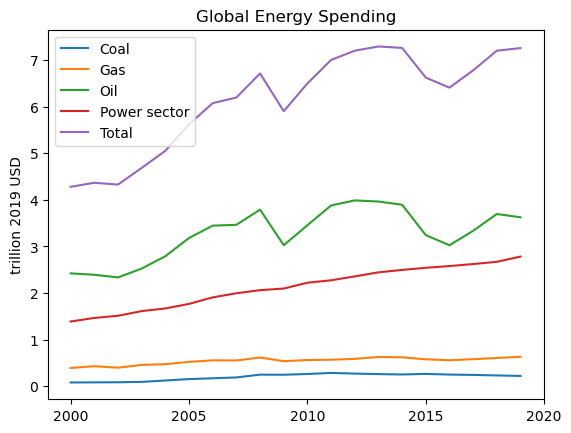

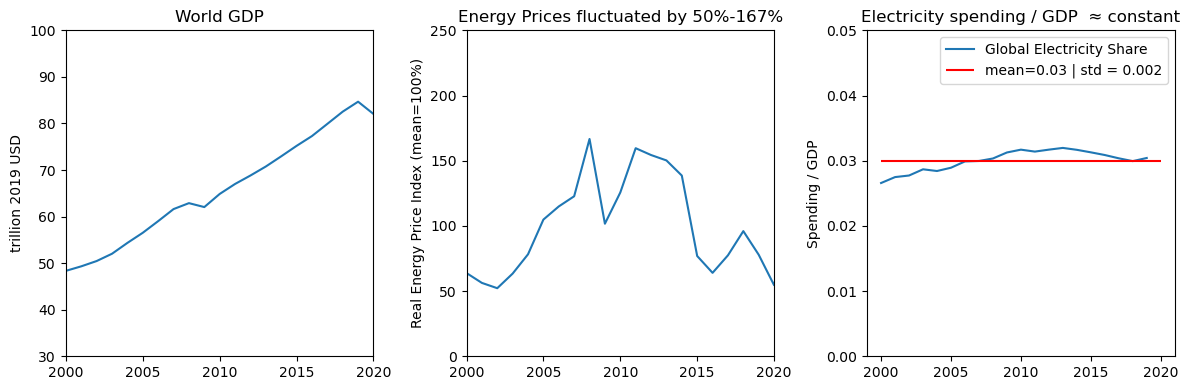

In [64]:
## Extract electricity_spending.csv from IEA website via playwright
#!pip install playwright==1.28.0 nest_asyncio
#!playwright install-deps
#!playwright install webkit
#import nest_asyncio
#nest_asyncio.apply()
#import asyncio
#import pandas as pd
#from playwright.async_api import async_playwright
#
#async def spending_data():
#    async with async_playwright() as p:
#        browser = await p.webkit.launch()
#        page = await browser.new_page()
#        await page.goto("https://www.iea.org/data-and-statistics/charts/global-end-use-spending-on-energy-2000-2020")
#        spending = await page.evaluate('''
#spending = {Type: [], Year: [], Spending_2019USD: []};
#Highcharts.charts[0].series.forEach((s)=>s.data.forEach(function(d) {
#    spending.Type.push(s.name);
#    spending.Year.push(d.x);
#    spending.Spending_2019USD.push(d.y);
#}));
#spending''')
#        await browser.close()
#    return spending
#
#spending = pd.DataFrame(asyncio.run(spending_data()))
#spending = spending[spending.Year.isin(spending.Year.unique()[spending.groupby('Year').size()==4])] # only keep years with full data
#spending = spending.append(spending.groupby('Year').sum().reset_index()).fillna('Total') # add 'Total'
#spending = spending.reset_index()
#spending.to_csv('data/global_electricity_spending.csv', index=False)

from matplotlib import pyplot as plt
import pandas as pd

spending = pd.read_csv("data/electricity_demand/global_electricity_spending.csv")

xticks = [yr for yr in range(2000, 2021) if yr%5 ==0]
spending.set_index('Year').groupby('Type').Spending_2019USD.plot(
    ylabel='trillion 2019 USD', legend=True, title='Global Energy Spending',
    xticks=xticks, xlabel="")
plt.savefig("figures/energy_sources.svg")
plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
# ax[0]
gdp = pd.read_csv('data/electricity_demand/API_NY.GDP.MKTP.KD_DS2_en_csv_v2_4770407.csv', skiprows=4).iloc[:,:-1]
gdp = gdp.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
               value_vars=[str(y) for y in range(1960, 2022)], var_name='Year', value_name='GDP_2015USD')
gdp.Year = gdp.Year.astype(int)
wgdp = gdp[gdp['Country Name'] == 'World'][['Year', 'GDP_2015USD']]
wgdp.GDP_2015USD = wgdp.GDP_2015USD / 1e12
wgdp.set_index('Year').GDP_2015USD.plot(
    ylim=[30,100], ylabel='trillion 2019 USD', title='World GDP',
    xlim=[2000, 2020], xticks=xticks, ax=ax[0], xlabel="")

# ax[1]
energy_price = pd.read_csv('data/electricity_demand/nominal_energy_price_index_FRED_PNRGINDEXA.csv') # 2016 = 100
price_deflator = pd.read_csv('data/electricity_demand/US_price_deflator_FRED_USAGDPDEFAISMEI.csv') # 2015 = 100
energy_price.DATE = energy_price.DATE.str[:4].astype(int)
price_deflator.DATE = price_deflator.DATE.str[:4].astype(int)
price_index = energy_price.set_index('DATE').join(price_deflator.set_index('DATE'))
price_index['Real Energy Price Index'] = price_index['PNRGINDEXA'] / price_index['USAGDPDEFAISMEI']
price_index['Real Energy Price Index'] = price_index['Real Energy Price Index'] / price_index.loc[2000:2020,'Real Energy Price Index'].mean() * 100
price_index['Real Energy Price Index'].plot(
    ylim=[0, 250], ylabel='Real Energy Price Index (mean=100%)', xlim=[2000,2020], ax=ax[1],
    title='Energy Prices fluctuated by 50%-167%', xticks=xticks, xlabel="")


# ax[2]
gdp_spending = spending.pivot(index='Year', columns='Type', values='Spending_2019USD').join(wgdp.set_index('Year'))
deflator_2015_2019 = 1.08
gdp_spending['Share'] = gdp_spending["Power sector"] / gdp_spending.GDP_2015USD / deflator_2015_2019
plot = gdp_spending.Share.plot(
    ylim=[0.00, 0.05], xticks=xticks, ax=ax[2], xlabel="",
    title=f'Electricity spending / GDP  ≈ constant',
    label='Global Electricity Share', ylabel= 'Spending / GDP'
).hlines(
    gdp_spending.Share.mean().round(3), xmin=2000, xmax=2020,
    label=f'mean={gdp_spending.Share.mean().round(3)} | std = {gdp_spending.Share.std().round(3)}',
    color="red"
)
plot.axes.legend()
f.tight_layout()
plt.savefig('figures/energy_spending.svg')

Despite significant income growth and historical price fluctuations, the expenditure share of electricity has stayed remarkably constant at $3\%\pm0.2\%$. This justifies our Cobb-Douglas aggregate demand, i.e. a price elasticity of 1. Notably, it is at odds with other studies which optimistically assume a reduction in future electricity demand due to "efficiency gains": if preferences are Cobb-Douglas, then efficiency gains will lead to an increased demand, such that the expenditure share stays exactly constant.

# Electricity Demand Variation: $\omega_t$

Thanks to our (conservative) assumption of perfect-complementarity between electricity consumption during different times of the year (i.e. an inter-temporal elasticity of zero), we can simply "estimate" $\omega_t$ by setting it to the electricity consumption during that subperiod within the "representative" year 2021. We pick a single year for each region not merely due to a lack of long-run high-frequency data, but also because we don't want to "smooth-out" demand variation by averaging across multiple years (as this would ignore the dispatchability benefits of fossil fuels).

In [ ]:
import requests, tqdm
import pandas as pd
generation = None
demand = None
for iso in (bar:=tqdm.tqdm("USA,IND,BGD,LKA,KOR,JPN,FRA,DEU,ITA,PRT,ESP,GBR,HUN,DNK,GRC,AUT".split(","))):
    bar.set_description(iso)
    generation = pd.concat([generation, pd.DataFrame(requests.get(
            "https://api.iea.org/rte/generation/timeseries",
            {"from": "2023-7-12", "to": "2024-7-11", "precision": "hour", "ISO3": iso}
        ).json())])
    demand = pd.concat([demand, pd.DataFrame(requests.get(
            "https://api.iea.org/rte/demand/timeseries",
            {"from": "2023-7-12", "to": "2024-7-11", "precision": "hour", "ISO3": iso}
        ).json())])

generation["Fuels"] = generation.Fuels.str.replace('Renewables (not specified)', "Other renewables")
generation.rename({"ISO3": "Country"}, inplace=True, axis=1)
demand = demand.rename({"ISO3": "Country"}, axis=1).set_index(["Country", "Date"])
generation = generation.pivot_table(index=["Country", "Date"], columns="Fuels", values="Value")
generation.to_csv("data/generation.csv")
demand.to_csv("data/demand.csv")

electricity_variability = pd.merge(
    generation, demand.rename(columns={"Value": "Demand"}),
    on=["Country", "Date"], how="inner"
)[["Solar", "Wind", "Demand"]].dropna()

electricity_variability.to_csv("data/electricity_variability.csv")


Unfortunately, Wind and Solar are merged into "other renewables" in the India dataset. To impute the individual series below, we interplotate nightly generation over the daytime can call the resulting timeseries "Wind", and subtract it from "other renewables" to get "Solar".

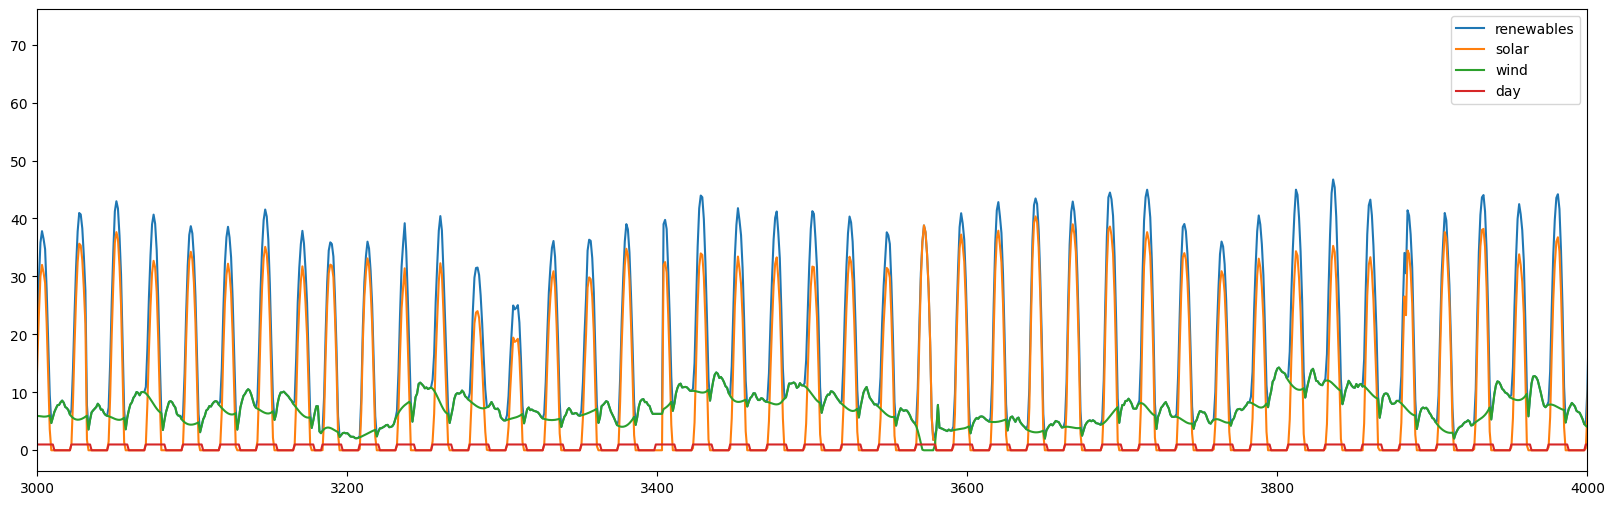

In [407]:
generation = pd.read_csv("data/generation.csv")
renewables = generation.loc[generation.Country == "IND"]["Other renewables"].values.flatten()
hour = pd.to_datetime(generation.loc[generation.Country == "IND"]["Date"]).dt.hour.values

day = np.isin(hour, list(range(7, 20)))
wind = renewables.copy()
wind[day] = np.nan
wind = pd.Series(wind).interpolate(method='linear').to_numpy()*0.5 + pd.Series(wind).interpolate(method='cubic').to_numpy()*0.5 # looks most realistic IMO
wind = np.clip(wind, 0, np.inf)
solar = np.clip(renewables-wind, 0, np.inf)
wind = renewables-solar

plt.figure(figsize=(20, 6))
plt.plot(renewables, label="renewables")
plt.plot(solar, label="solar")
plt.plot(wind, label="wind")
plt.plot(day, label="day")
offset = 3000
plt.xlim(offset, 1000+offset)
plt.legend()


generation.loc[generation.Country == "IND", "Solar"] = solar
generation.loc[generation.Country == "IND", "Wind"] = wind
generation.to_csv("data/generation.csv", index=False)
demand = pd.read_csv("data/demand.csv")
electricity_variability = pd.merge(
    generation, demand.rename(columns={"Value": "Demand"}),
    on=["Country", "Date"], how="inner"
).set_index(["Country", "Date"])[["Solar", "Wind", "Demand"]].dropna()

electricity_variability.to_csv("data/electricity_variability.csv")


# Combining Parameters For Simulation

In [54]:
import pandas as pd
import numpy as np


# initialize some helpful mappings 
map_iso_regions = pd.read_csv("data/iso_regions.csv")
map_tech_names = { # fixes inconsistent tech names in Jacobson et al
    "Onshore wind": "On-shore wind", #"Offshore wind": "Off-shore wind",
    #"Com/gov/Indus roof PV system": "PV commercial rooftop", 
    "Solar PV plant": "PV utility crystalline fixed", #'Res. roof PV system': "PV residential rooftop",
    "Hydroelectric plant": "Hydropower", 'Advanced pulverized coal': 'Advanced pulverized coal',
    'Combined cycle conventional': 'Combined cycle conventional', 'Nuclear, APWR': 'Nuclear, APWR'
}
EU = ["AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", "DEU",
      "GRC", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD", "POL", "PRT",
      "ROU", "SVK", "SVN", "ESP", "SWE"]

# country specific LCOE estimates of fossil fuels (missing in Jacobson et al data)
gas_lcoe = pd.read_excel("data/IRENA-Datafile-RenPwrGenCosts-in-2023-v1.xlsx", sheet_name="Fig 1.6", header=[8], nrows=21, index_col=0, usecols=[2]+list(range(3,14)))
coal_lcoe = pd.read_excel("data/IRENA-Datafile-RenPwrGenCosts-in-2023-v1.xlsx", sheet_name="Fig 1.6", header=[8],nrows=21, index_col=0, usecols=[2]+list(range(18,29)))
coal_lcoe.columns = gas_lcoe.columns
fossil_lcoe = (pd.concat({"Advanced pulverized coal": coal_lcoe, "Combined cycle conventional": gas_lcoe}, axis=0, names=["Technology", "Country"])
               .reset_index()
               .assign(Country=lambda x: x.Country.replace(map_iso_regions.set_index("name")["alpha-3"]))
               .assign(Country=lambda x: x.Country.replace({"Republic of South Korea": "KOR", "Türkiye": "TUR", "United Kingdom": "GBR", "United States": "USA"}))
               .set_index(["Technology", "Country"])
)

# load cost and potential capacity estimates from Jacobson et al: https://web.stanford.edu/group/efmh/jacobson/Articles/I/WWS-145-Countries.html
costs = 0
cost_multiplier = 0
scenarios = ["HCLB", "LCHB"]
for scenario in scenarios:
    cost = pd.read_excel('data/145-Spreadsheet.xlsx', sheet_name='Cost of delivered electricity',  skiprows=18, nrows=31, header=[0,1,2,3])
    cost = cost.set_index(cost['INPUT PARAMETERS AND INTERMEDIATE RESULTS']['TECHNOLOGY'].to_numpy()[:,0]) 
    initial_cost = cost['RESULTS, TECHNOLOGY BASE YEAR 2020']['Cost summary ($/kWh) (Year-2020 dollars)']['Amortized initial cost, generation'][scenario]
    fixed_operating = cost['RESULTS, TECHNOLOGY BASE YEAR 2020']['Cost summary ($/kWh) (Year-2020 dollars)']['Fixed operating costs'][scenario]
    variable_operating = cost['RESULTS, TECHNOLOGY BASE YEAR 2020']['Cost summary ($/kWh) (Year-2020 dollars)']['Variable operating costs'][scenario]
    fuel_cost = cost['RESULTS, TECHNOLOGY BASE YEAR 2020']['Cost summary ($/kWh) (Year-2020 dollars)']['Fuel cost'][scenario]
    transmission_cost = cost['RESULTS, TECHNOLOGY BASE YEAR 2020']['Cost summary ($/kWh) (Year-2020 dollars)']['Transmission, distribution, storage, and related'][scenario]
    annuity_factor = cost['INPUT PARAMETERS AND INTERMEDIATE RESULTS']['TIME FRAME']['Cont. annuity factor (1/years discounted) '][scenario] # r/(1-e^(-r*lifetime)) 
    lifetime = cost['INPUT PARAMETERS AND INTERMEDIATE RESULTS']['TIME FRAME']["Facility life (years)"][scenario]
    lcoe = cost['RESULTS, TECHNOLOGY BASE YEAR 2020']['Cost summary ($/kWh) (Year-2020 dollars)']['TOTAL LCEO ($/kWh) (Year-2020 dollars)'][scenario]
    costs += pd.DataFrame({
        "c_Q": fuel_cost + variable_operating,                          # $/kWh (prop. to usage)
        "c_O": (fixed_operating + transmission_cost)*24*365,            # $/kW/yr (prop. to installed capacity)
        "c_K": initial_cost*24*365/annuity_factor,                      # $/kW (prop. to added capacity)
        "Lifetime": lifetime,                                           # years
        "LCOE": lcoe                                                    # to compute country-specific cost_multiplier below
    }).reset_index(names="Technology").set_index(["Technology"]).loc[map_tech_names.values()]/len(scenarios)

    cost_multiplier += (
        pd.read_excel('data/145-Spreadsheet.xlsx', sheet_name='Cost multipliers by country',  skiprows=2, nrows=191, header=[0,1])
        .pipe(lambda x: pd.DataFrame(x.filter([c for c in x.columns if c[1] in ["Country", scenario]], axis=1)))
        .droplevel(1, axis="columns")
        .rename({"Unnamed: 0_level_0": "Country"}, axis=1)
        .rename(map_tech_names, axis=1)
        .query("Country in @map_iso_regions.name")
        .assign(Country=lambda x: x.Country.replace(map_iso_regions.set_index('name')["alpha-3"]))
        .set_index("Country").pipe(lambda x: x.assign(**{
            "Advanced pulverized coal": fossil_lcoe.mean(1).loc["Advanced pulverized coal"]/fossil_lcoe.mean(1).loc["Advanced pulverized coal"].loc["USA"],
            "Combined cycle conventional": fossil_lcoe.mean(1).loc["Combined cycle conventional"]/fossil_lcoe.mean(1).loc["Combined cycle conventional"].loc["USA"],
            "Nuclear, APWR": 1.0,
        })).fillna(1.0).reset_index()
        .melt(id_vars="Country", value_vars=map_tech_names.values(), var_name="Technology", value_name="Multiplier")
        .set_index(["Country", "Technology"])
    )/len(scenarios)
#cost_multiplier = (
#    pd.read_excel('data/145-Spreadsheet.xlsx', sheet_name='Cost multipliers by country',  skiprows=2, nrows=191, header=[0,1])
#    .pipe(lambda x: pd.DataFrame(x.filter([c for c in x.columns if not c[1].startswith("LCHB")], axis=1)))
#    .droplevel(1, axis="columns")
#    .rename({"Unnamed: 0_level_0": "Country"}, axis=1)
#    .rename(map_tech_names, axis=1)
#    .query("Country in @map_iso_regions.name")
#    .assign(**{
#        "Country": lambda x: x.Country.replace(map_iso_regions.set_index('name')["alpha-3"]),
#        "Advanced pulverized coal": 1.0,
#        "Combined cycle conventional": 1.0,
#        "Nuclear, APWR": 1.0,
#    })
#    .melt(id_vars="Country", value_vars=map_tech_names.values(), var_name="Technology", value_name="Multiplier")
#    .set_index(["Country", "Technology"])
#)
# impute missing cost multipliers in Jacobson data using IEA estimates of LCOE
#fossil_cost_multiplier = pd.read_csv("data/fossil_cost_multiplier.csv", index_col=0)
#for tech in fossil_cost_multiplier.columns:
#    ref = cost_multiplier.loc[("USA", tech), "Multiplier"]
#    cost_multiplier.loc[("CHN", tech), "Multiplier"] = fossil_cost_multiplier.loc["CHN", tech]*ref
#    cost_multiplier.loc[("IND", tech), "Multiplier"] = fossil_cost_multiplier.loc["IND", tech]*ref
#    for c in EU: cost_multiplier.loc[(c, tech), "Multiplier"] = fossil_cost_multiplier.loc["EU", tech]*ref

# country specific capacity constraints
capacity_constraints = (
    pd.read_excel('data/145-Spreadsheet.xlsx', sheet_name='WWS Tech Potential ', skiprows=3, nrows=190, usecols=range(11))
    .rename(map_tech_names, axis=1)
    .query("Country in @map_iso_regions.name")
    .assign(**{
        "Country": lambda x: x.Country.replace(map_iso_regions.set_index('name')["alpha-3"]),
        "Advanced pulverized coal": float("inf"),
        "Combined cycle conventional": float("inf"),
        "Nuclear, APWR": float("inf"),
    })
    .melt(id_vars="Country", value_vars=map_tech_names.values(), var_name="Technology", value_name="Potential")
    .set_index(["Country", "Technology"])
)

# We infer preinstalled capacity from generation kWh/365/24, as cost estimates are in terms of delivered electricity (net of capacity factors)
# we'll infer "effective" capacity (adjusted for capacity factors) from generation data, rather than using nominal capacity
#preinstalled = pd.read_excel("data/E_gen_r_230822.081459.xlsx", skiprows=5, skipfooter=1, index_col=0, sheet_name=None) # from  https://www.eia.gov/outlooks/ieo/data/excel/E_cap_r_230822.081459.xlsx at https://www.eia.gov/outlooks/ieo/data.php
#labels = pd.read_excel("data/E_gen_r_230822.081459.xlsx", skiprows=2, skipfooter=1, index_col=0, sheet_name=None)
#df_preinstalled = (
#    pd.concat([preinstalled[sheet][2022].rename(labels[sheet].index[0].split("generation: ")[1].split(", Reference case")[0]) for sheet in preinstalled], axis=1)
#    .rename(str.strip, axis="index").T
#    .rename(
#        index={"Western Europe": "EU", "United States": "USA", "India": "IND", "China": "CHN",
#               "Russia": "RUS", "Mexico": "MEX", "Brazil": "BRA", "Australia and New Zealand": "AUS",
#               "South Korea": "KOR", "Canada": "CAN"},
#        columns={
#            "Solar": "PV utility crystalline fixed", "Wind": "On-shore wind", "Hydro": "Hydropower", "Nuclear": "Nuclear, APWR", 
#            "Natural gas": "Combined cycle conventional", "Coal": "Advanced pulverized coal"
#        }
#    )
#    .reset_index(names="Country")
#    .melt(id_vars="Country", value_vars=map_tech_names.values(), var_name="Technology", value_name="Preinstalled (GW)") # still in TWh here
#    .assign(**{"Preinstalled (GW)": lambda x: x["Preinstalled (GW)"] / 365 / 24 * 1e3}) # from TWh to GW
#    .set_index(["Country", "Technology"])
#)
# We infer preinstalled capacity from generated kWh/365/24, as cost estimates are in terms of delivered electricity (net of capacity factors)
df_preinstalled = (pd.read_csv('data/electricity-prod-source-stacked.csv') # from https://ourworldindata.org/grapher/electricity-prod-source-stacked, due to Ember (2024)
              .pipe(lambda x: x.assign(Code=x.Code.where(x.Entity!="European Union (27)", "EU" ).where(x.Entity!="World", "WORLD")))
              .drop('Entity', axis=1)
              .rename({"Code" : "Country"}, axis=1)
              .set_index(["Country", "Year"])
              .pipe(lambda x: x.rename(dict(zip(x.columns, x.columns.str.slice(17,-75).str.capitalize())), axis=1))
              .rename(columns={"Solar": "PV utility crystalline fixed", "Wind": "On-shore wind", "Hydro": "Hydropower",
                               "Nuclear": "Nuclear, APWR", "Gas": "Combined cycle conventional", "Coal": "Advanced pulverized coal"})
              .drop(['Excluding bioenergy', 'Bioenergy', 'Oil'], axis=1)
              .reset_index().dropna()
              .query("(Year>=2015) & (Year<2023)")
              .melt(id_vars=['Country', 'Year'], var_name='Technology')
              .pivot(columns='Year', index=["Country","Technology"], values='value')
              .add_prefix('Preinstalled ', axis=1).add_suffix(' (GW)', axis=1)
              .mul(1000/365/24) # from TWh to GW
)

# we get battery and pumped hydro capacity from the EIA capacity data
preinstalled = pd.read_excel("data/E_cap_r_230822.081459.xlsx", skiprows=5, skipfooter=1, index_col=0, sheet_name=None) # from  https://www.eia.gov/outlooks/ieo/data/excel/E_cap_r_230822.081459.xlsx at https://www.eia.gov/outlooks/ieo/data.php
labels = pd.read_excel("data/E_cap_r_230822.081459.xlsx", skiprows=2, skipfooter=1, index_col=0, sheet_name=None)
df_preinstalled = pd.concat([df_preinstalled, (
    pd.concat([preinstalled[sheet][2022].rename(labels[sheet].index[0].split("capacity: ")[1].split(", Reference case")[0]) for sheet in preinstalled], axis=1)
    .rename(str.strip, axis="index").T
    .rename(
        index={"Western Europe": "EU", "United States": "USA", "India": "IND", "China": "CHN",
               "Russia": "RUS", "Mexico": "MEX", "Brazil": "BRA", "Australia and New Zealand": "AUS",
               "South Korea": "KOR", "Canada": "CAN"},
    )
    .reset_index(names="Country")
    .melt(id_vars="Country", value_vars=["Pumped hydro", "Battery storage"], var_name="Technology", value_name="Preinstalled 2022 (GW)") # in GW
    .pipe(lambda x: x.assign(**dict([ # assume hydro was constant and batteries grew linearly since 2015
        (f"Preinstalled {yr} (GW)", x["Preinstalled 2022 (GW)"].where(x.Technology=="Pumped hydro", x["Preinstalled 2022 (GW)"]*(yr-2015)/7))
          for yr in range(2015, 2022)
    ])))
    .set_index(["Country", "Technology"])
)], axis=0)


# Load data on electricity generation and demand variability
map_tech_names.update({"Pumped hydro": "Pumped hydro", "Battery storage": "Battery storage"})
variability = (
    pd.read_csv("data/electricity_variability.csv")
    .replace({"Country": {**dict(zip(EU, ["EU"]*len(EU)))}})
    .pipe(lambda x: pd.concat([x, x.query("Country=='USA'").replace({"Country": {"USA": "CHN"}})], axis=0)) # will use US variability for CHN (similar size and latitude, can't find any data for China)
    .set_index("Country").groupby(["Country", "Date"])
    .pipe(lambda g: g.agg(lambda x, gsize: x.sum() if len(x) == gsize.loc[x.index[0]] else float("nan"), g.size().groupby("Country").max()))
    .dropna() # removes all nans, which per the previous line are dates where some EU countries don't have data
    .groupby("Country")
    .apply(lambda x: x
        .sample((n_hours_sampled := 1024), replace=False, random_state=(seed := 1)) # we only loadmatch for a random subsample of 1024 non-nan hours from the year
        .apply(lambda x: x.clip(0)/x.clip(0).mean(), 0) # USA Solar generation data contains tiny negative values which we remove here
        .pipe(lambda x: x.assign( Period = range(len(x)) ))
    )
    .reset_index(level=1, drop=True).reset_index("Date").drop("Date", axis=1)
    .rename(columns={"Solar": "PV utility crystalline fixed", "Wind": "On-shore wind"})
    .pipe(lambda x: x.assign(**dict((v, 1) for v in map_tech_names.values() if v not in x.columns)))
    .reset_index()
    .melt(id_vars=["Country", "Period"], var_name="Technology", value_name="Amount_During_Hour_")
    .pivot(index=["Country", "Technology"], columns="Period", values="Amount_During_Hour_").add_prefix("Amount_During_Hour_")
)



# merge technology data 
gdp_2020 = pd.read_csv("data/combined_projections.csv").set_index("Year").loc[2020].set_index("Country").gdp70
technologies = (
    pd.concat([cost_multiplier, capacity_constraints], axis=1)
    .reset_index().set_index("Technology")
    .groupby("Country")
    .apply(lambda x: x.assign(
        c_Q = lambda x: costs.c_Q * x.Multiplier,
        c_O = lambda x: costs.c_O * x.Multiplier,
        c_K = lambda x: costs.c_K * x.Multiplier,
        Lifetime = costs.Lifetime
    ), include_groups=False)
    .drop(columns=["Multiplier"]).reset_index()
    .query("Country in @gdp_2020.index.get_level_values('Country')")
    .assign(iso = lambda x: x.Country)
    .replace({"Country": dict(zip(EU, ["EU"]*len(EU)))})
    .query("Country.str.len() <= 3")
    .groupby(["Country", "Technology"])
    .apply(lambda x: pd.Series({
        "c_Q ($/kWh)": np.average(x.c_Q, weights=gdp_2020.loc[x.iso]),
        "c_O ($/kW/yr)": np.average(x.c_O, weights=gdp_2020.loc[x.iso]),
        "c_K ($/kW)": np.average(x.c_K, weights=gdp_2020.loc[x.iso]),
        "Lifetime (yrs)": np.average(x.Lifetime, weights=gdp_2020.loc[x.iso]),
        "Potential (GW)": x.Potential.sum()/1e3, # from MW to GW
    }), include_groups=False)
    .join(df_preinstalled, how="outer") # in GW
)

# save combined parameters
combined_parameters = technologies.join(variability, how="right")

# based on https://atb.nrel.gov/electricity/2023/pumped_storage_hydropower
combined_parameters.loc[(slice(None), "Pumped hydro"), "c_Q ($/kWh)"]    = 0.000514
combined_parameters.loc[(slice(None), "Pumped hydro"), "c_O ($/kW/yr)"]  = 18.6
combined_parameters.loc[(slice(None), "Pumped hydro"), "c_K ($/kW)"]     = 3500
combined_parameters.loc[(slice(None), "Pumped hydro"), "Lifetime (yrs)"] =  30
combined_parameters.loc[(slice(None), "Pumped hydro"), "Storage duration (kWh/kW)"] = 10
combined_parameters.loc[(slice(None), "Pumped hydro"), "Storage efficiency (%)"] = 0.7
combined_parameters.loc[(slice(None), "Pumped hydro"), "Potential (GW)"] = 1.1 * combined_parameters.loc[(slice(None), "Pumped hydro"), "Preinstalled 2022 (GW)"]

# capturing Fig.6 in https://www.nrel.gov/docs/fy23osti/85332.pdf
combined_parameters.loc[(slice(None), "Battery storage"), "c_Q ($/kWh)"] = 0
combined_parameters.loc[(slice(None), "Battery storage"), "c_O ($/kW/yr)"] = 30
combined_parameters.loc[(slice(None), "Battery storage"), "c_K ($/kW)"] = 2000 # corresponds to $500/kWh for a 4-hour battery system
combined_parameters.loc[(slice(None), "Battery storage"), "Lifetime (yrs)"] = 15
combined_parameters.loc[(slice(None), "Battery storage"), "Storage duration (kWh/kW)"] = 4
combined_parameters.loc[(slice(None), "Battery storage"), "Storage efficiency (%)"] = 0.85
combined_parameters.loc[(slice(None), "Battery storage"), "Potential (GW)"] = float("inf")

combined_parameters.to_csv("data/combined_parameters.csv")

# look at EU example
combined_parameters.loc["USA"]

/Users/jonasmetzger/miniforge3/envs/pytorch/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/jonasmetzger/miniforge3/envs/pytorch/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,c_Q ($/kWh),c_O ($/kW/yr),c_K ($/kW),Lifetime (yrs),Potential (GW),Preinstalled 2015 (GW),Preinstalled 2016 (GW),Preinstalled 2017 (GW),Preinstalled 2018 (GW),Preinstalled 2019 (GW),...,Amount_During_Hour_1016,Amount_During_Hour_1017,Amount_During_Hour_1018,Amount_During_Hour_1019,Amount_During_Hour_1020,Amount_During_Hour_1021,Amount_During_Hour_1022,Amount_During_Hour_1023,Storage duration (kWh/kW),Storage efficiency (%)
Technology,,,,,,,,,,,,,,,,,,,,,
Advanced pulverized coal,0.026407,415.607431,7896.931349,52.5,inf,154.383562,141.455479,137.652968,131.220320,110.155251,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN
Battery storage,0.000000,30.000000,2000.000000,15.0,inf,0.000000,0.902914,1.805829,2.708743,3.611657,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.0,0.85
Combined cycle conventional,0.038780,375.243823,2282.199443,47.5,inf,152.223744,157.341324,147.995434,167.708904,181.028539,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN
Demand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.856282,0.919391,0.855441,0.970982,0.922364,0.928514,0.946273,0.850760,NaN,NaN
Hydropower,0.004690,358.168770,6395.510703,85.0,7.914500e+01,27.852740,29.809361,33.543379,32.719178,32.261416,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN
"Nuclear, APWR",0.008653,507.797053,14262.219272,62.5,inf,91.002283,91.973744,91.889269,92.132420,92.398402,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN
On-shore wind,0.000000,443.437550,3816.907835,30.0,3.375599e+03,21.771689,25.912100,29.029680,31.126712,33.776256,...,1.334923,0.619098,1.073559,1.596370,1.018910,0.505979,1.095651,1.485269,NaN,NaN
PV utility crystalline fixed,0.000000,376.113121,5641.442234,48.5,4.488653e+05,4.455479,6.263699,8.821918,10.657534,12.202055,...,0.021189,0.021676,0.036239,0.007531,0.030249,2.065560,0.998092,0.004676,NaN,NaN
Pumped hydro,0.000514,18.600000,3500.000000,30.0,2.409330e+01,21.903000,21.903000,21.903000,21.903000,21.903000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.0,0.70
